# Notebook magique with AutoML

TO DO:
- remove outliers: implement new fucntion + get right percentage
- test different numbers of topics and clusters 

See 
https://github.com/parklize/cikm2020-analyticup?fbclid=IwAR0Ti_pF7HrIO5ELFlvA1b2FEL_D68xlu_XdXeFxyARzBfY5U7a040klHTM

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sns as sns
from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit  # pip install verstack


# Load the training data
train_data = pd.read_csv("data/train.csv")

# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")

In [2]:
X = train_data.drop('retweets_count',axis=1)
y = train_data['retweets_count']

## Study, data visualization

In [6]:
import seaborn as sbn

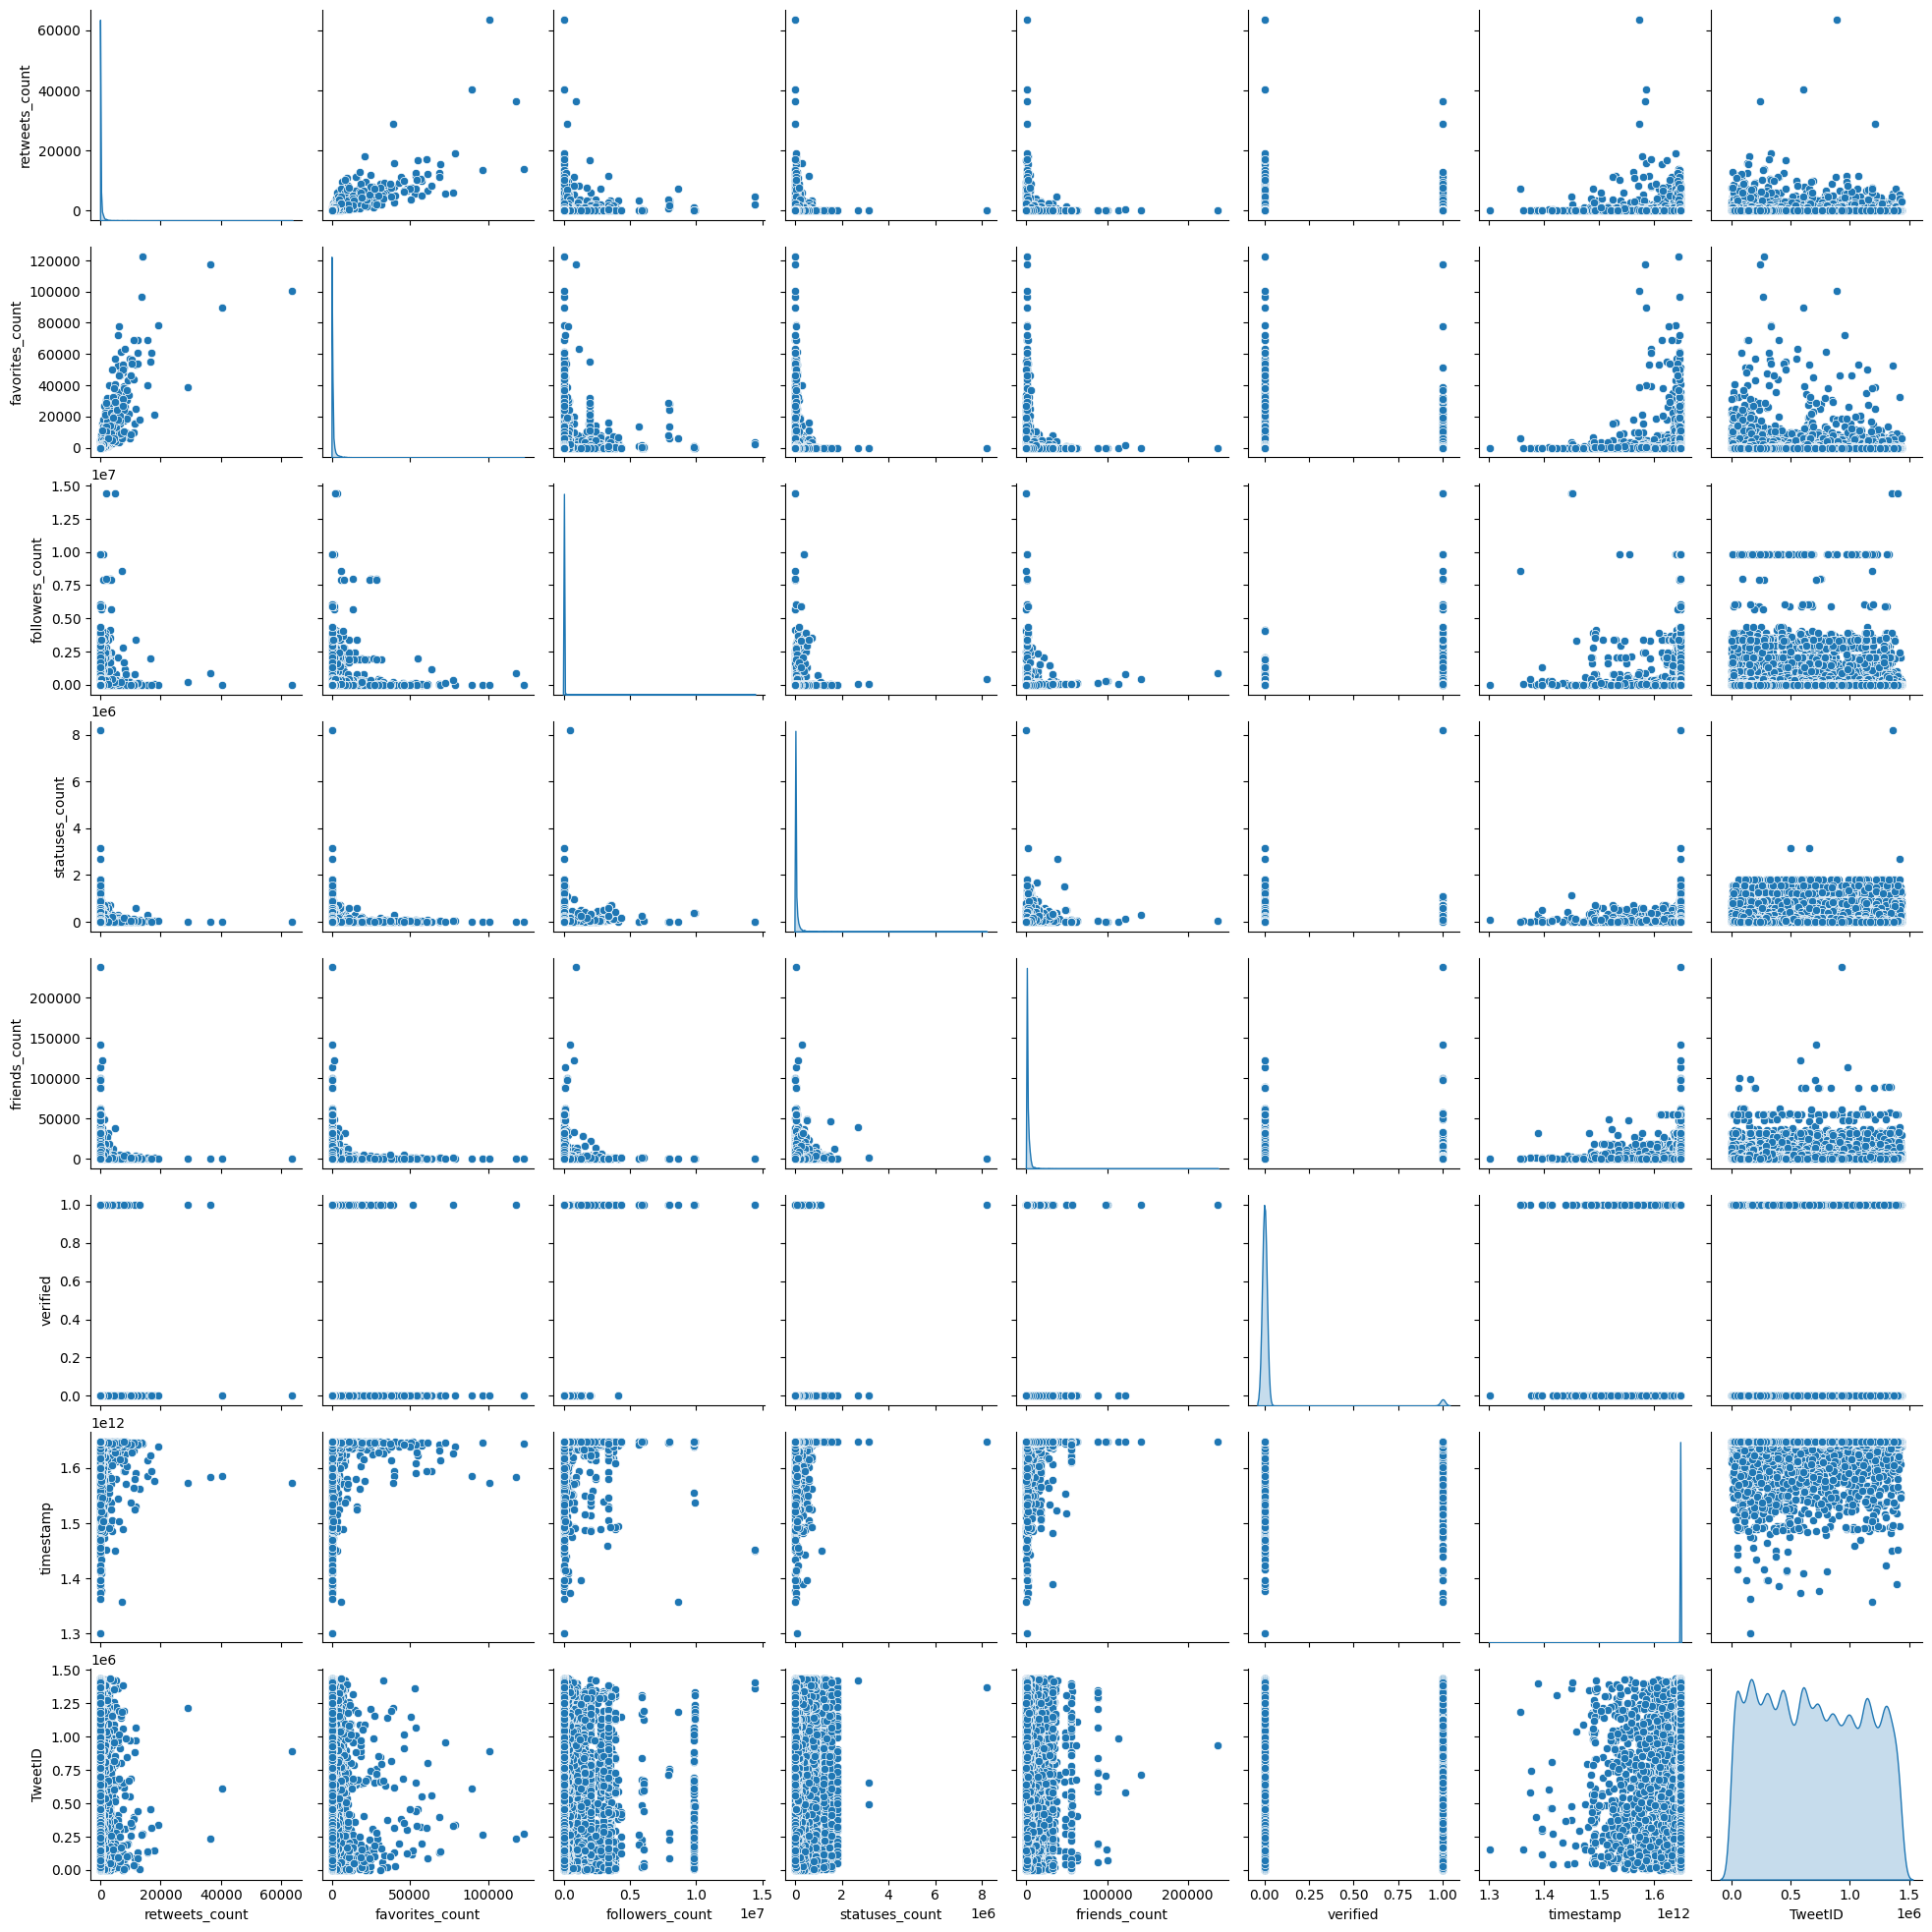

In [7]:
sbn.pairplot(train_data, diag_kind='kde')

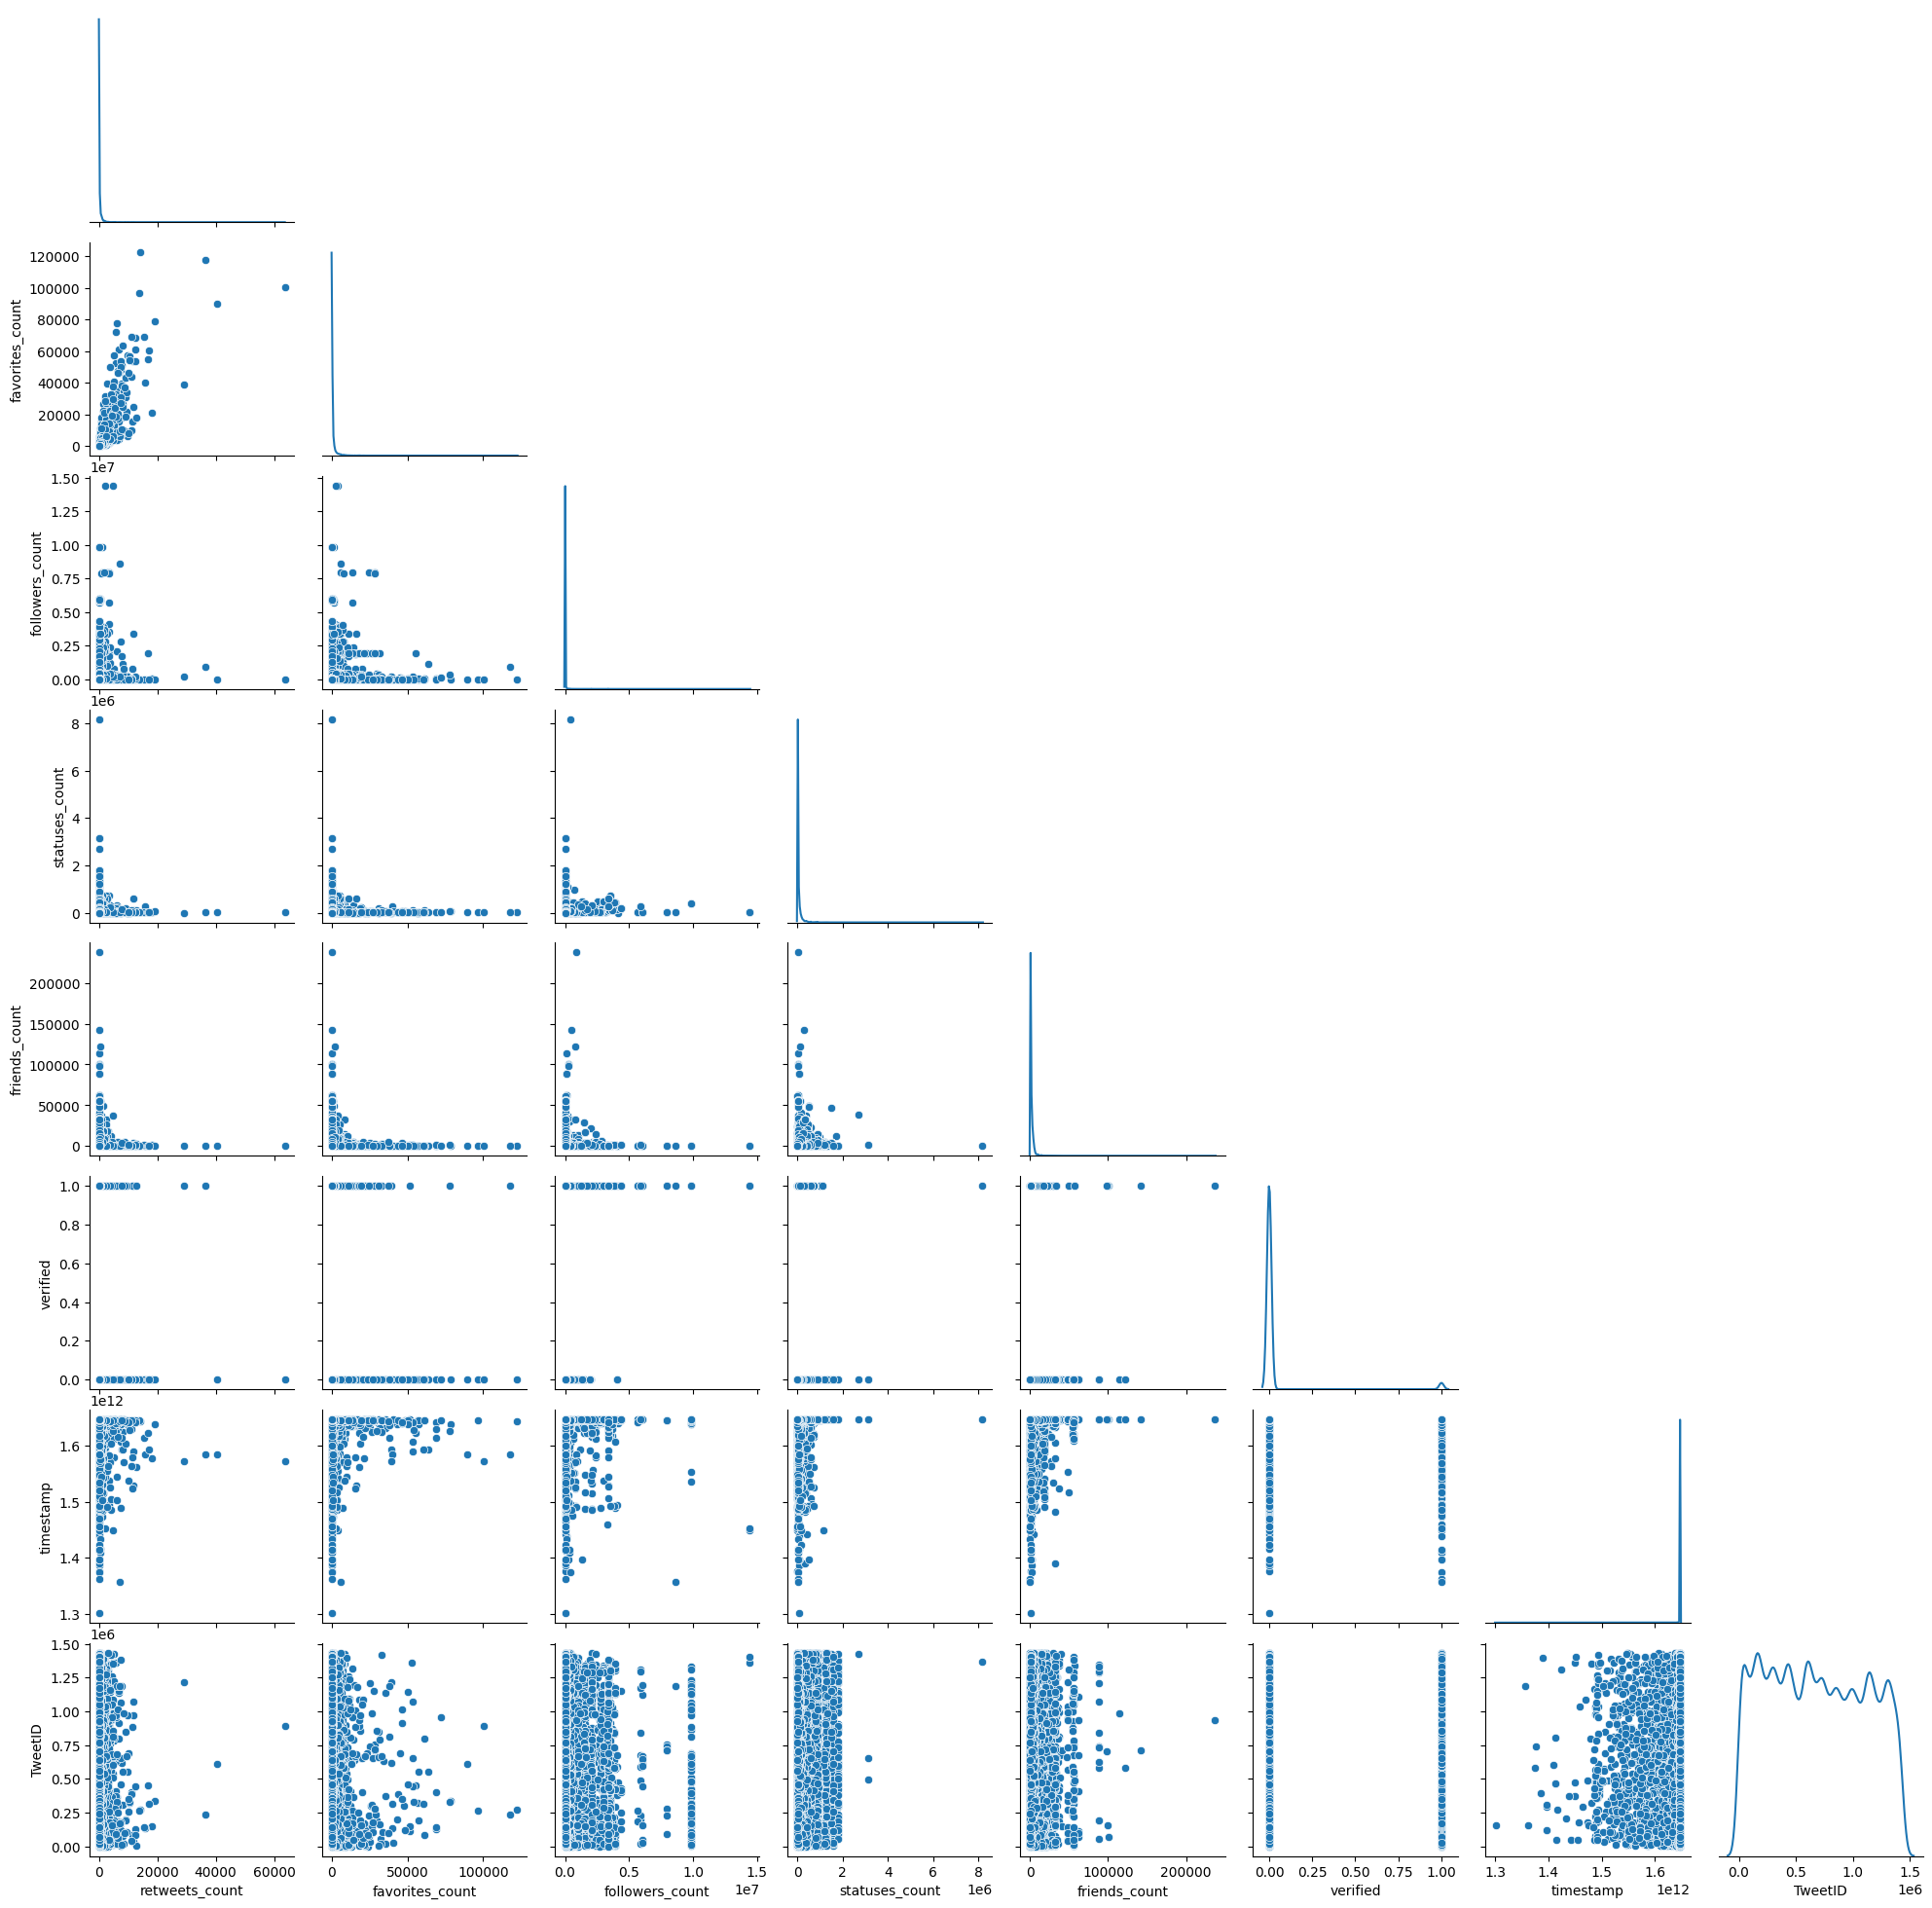

In [8]:
g = sbn.PairGrid(train_data, diag_sharey=False, corner=True)
g.map_lower(sbn.scatterplot)
g.map_diag(sbn.kdeplot)

In [4]:
def visualize_retweets(n_max, n_min=-1, k=True, b=30):
    sbn.displot(y[y < n_max][n_min < y], kde=k, bins=b)

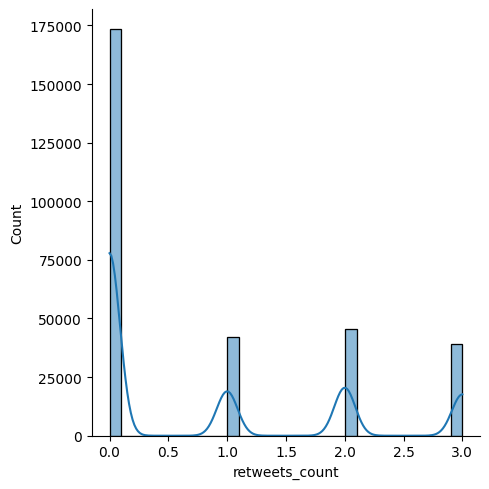

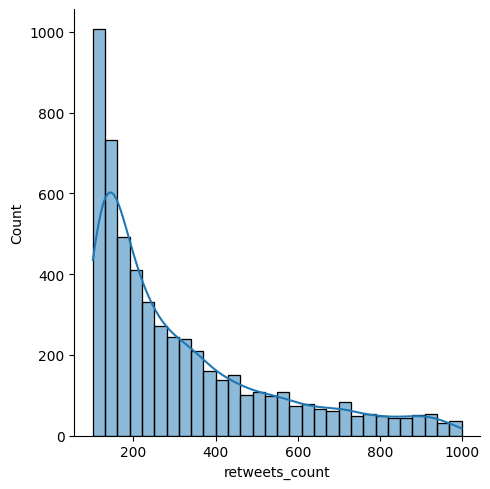

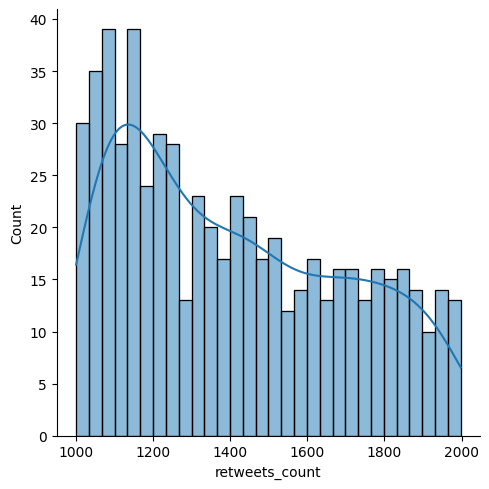

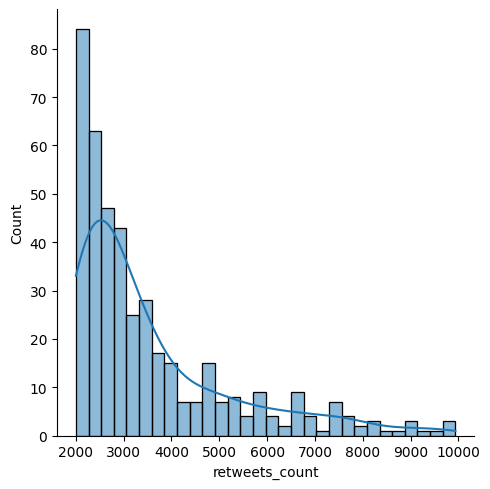

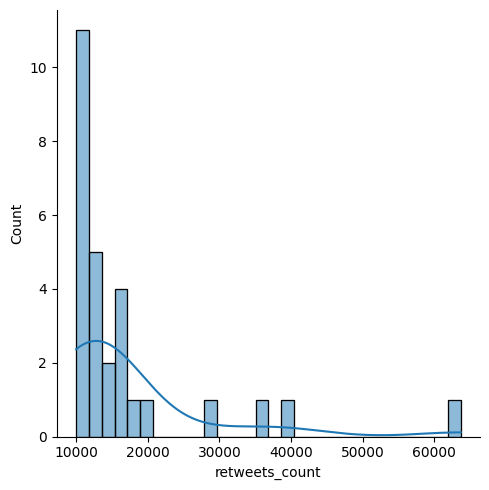

In [5]:
visualize_retweets(4)
visualize_retweets(1000, 100)
visualize_retweets(2000, 1000)
visualize_retweets(10000, 2000)
visualize_retweets(70000, 10000)

## Outliers

In [6]:
# remove outliers with quartile
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    df = df[(df[col] >= q1 - 5 * iqr) & (df[col] <= q3 + 5 * iqr)]
    return df

In [7]:
# remove outliers with given percentage p
def remove_outliers_percentage(df, col, p):
    q = df[col].quantile(1 - p / 100)
    df = df[df[col] < q]
    return df

In [3]:
# remove outliers with retweets_count above n
def remove_outliers_above(df, col, n):
    df = df[df[col] < n]
    return df

In [3]:
def percentage_outliers_above(df, col, n):
    z = df[col].copy()
    z[z < n] = 0
    print("n:")
    print(n)
    print("Percentage of outliers:")
    print(len(z[z>n])/len(z) * 100)

In [5]:
percentage_outliers_above(train_data, 'retweets_count', 7000)

n:
7000
Percentage of outliers:
0.01553808384350042


## Split data

In [4]:
# split data
#X_train, X_test, y_train, y_test = scsplit(
#    train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.8, test_size=0.2)

# We remove the actual number of retweets from our features since it is the value that we are trying to predict
# X_train = X_train.drop(['retweets_count'], axis=1)
# X_test = X_test.drop(['retweets_count'], axis=1)


# split data using sklearn
from sklearn.model_selection import train_test_split

X = train_data.drop('retweets_count',axis=1)
y = train_data['retweets_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# reinsert
X_train['retweets_count'] = y_train
# remove outliers according to visualization
X_train = remove_outliers_above(X_train, 'retweets_count', 7000)
# split again
y_train = X_train['retweets_count']
X_train = X_train.drop('retweets_count',axis=1)

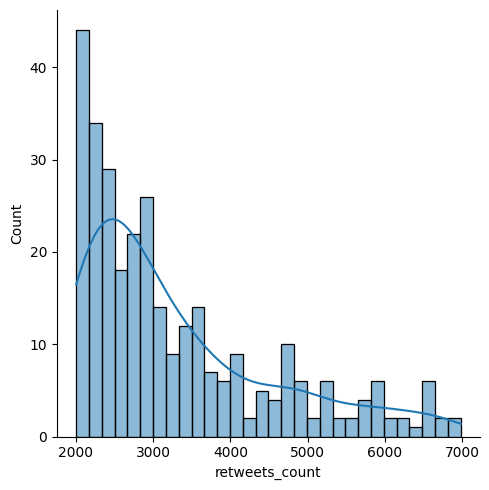

In [13]:
# verify the removal of outliers
sbn.displot(y_train[y_train < 10000][2000 < y_train], kde=True, bins=30)

## Data processing functions

In [6]:
def feature_engineering(in_df):
    rs_df = in_df

    # mentions is always empty -> DROP Mention
    rs_df = rs_df.drop(['mentions'], axis=1)

    # add a column to data which counts url
    rs_df['url_count'] = rs_df['urls'].str.count('http')
    rs_df = rs_df.drop(['urls'], axis=1)
    # add a column to data which gives length of hashtags
    # TO DO
    # add columns to data which makes ratios
    rs_df['followers_friends'] = rs_df['followers_count'] / \
        (rs_df['friends_count'].apply(lambda x: x+1))
    
    return rs_df

In [7]:
from datetime import datetime


def time_engineering(in_df):
    rs_df = in_df
    rs_df["hour"] = rs_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000).hour))
    rs_df["day"] = rs_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000)).weekday())
    rs_df["week_in_month"] = rs_df['timestamp'].apply(
        lambda t: (datetime.fromtimestamp(t//1000).day)//7)
        
    rs_df.drop(['timestamp'], axis=1)

    return rs_df

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords


def extract_topic(df):
    rs_df = df
    rs_df['hashtags'] = rs_df['hashtags'].apply(
        lambda x: x.replace('[', '').replace(']', '').replace("'", ''))
    #join text and hashtags
    rs_df['total_text'] = rs_df['text'] + ' ' + rs_df['hashtags']
    vectorizer = TfidfVectorizer(min_df=1, max_features=None, stop_words=stopwords.words('french'))
    vector = vectorizer.fit_transform(df['text'])
    svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
    svd.fit(vector)
    topic=svd.transform(vector)
    rs_df['topic_1'] = topic[:,0]
    rs_df['topic_2'] = topic[:,1]
    rs_df['topic_3'] = topic[:,2]
    rs_df['topic_4'] = topic[:,3]
    rs_df['topic_5'] = topic[:,4]
    return rs_df

In [9]:
from textblob import TextBlob  # pip install textblob-fr
from textblob_fr import PatternTagger, PatternAnalyzer


def text_engineering(in_df):
    rs_df = in_df
    # add columns related to sentiment analysis
    rs_df['polarity'] = rs_df['text'].apply(lambda x: TextBlob(
        x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[0])
    rs_df['subjectivity'] = rs_df['text'].apply(lambda x: TextBlob(
        x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[1])
    # drop the text column
    rs_df = rs_df.drop(['text'], axis=1)

    return rs_df

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords


def hashtags_engineering(in_df):
    rs_df = in_df
    # make a string of the list
    rs_df['hashtags'] = rs_df['hashtags'].apply(
        lambda x: x.replace('[', '').replace(']', '').replace("'", ''))

    # has hashtags or not
    rs_df['has_hashtags'] = rs_df['hashtags'].apply(
        lambda x: 0 if x == '' else 1)

    # drop the hashtags column
    rs_df = rs_df.drop(['hashtags'], axis=1)
    return rs_df

In [11]:
#import kmeans
from sklearn.cluster import KMeans


def extract_cluster(df,columns):
    rs_df = df
    rs_df['cluster'] = KMeans(n_clusters=100, random_state=0).fit_predict(rs_df[columns].values)
    return rs_df

## Scaler

In [20]:
def logtransformdrop(dataframe, cols):
    for col in cols:
        dataframe[col] = dataframe[col].apply(lambda x: np.log10(int(x)+1))
    return dataframe

## Data processing

In [12]:
col = ['TweetID', 'followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'verified', 'url_count', 'followers_friends',
       'hour', 'day','week_in_month', 'polarity', 'subjectivity', 'has_hashtags', 'topic_1','topic_2', 'topic_3','topic_4', 'topic_5','cluster']

In [13]:
new_X_train = feature_engineering(X_train)
new_X_train = time_engineering(new_X_train)
new_X_train = extract_topic(new_X_train)
new_X_train = text_engineering(new_X_train)
new_X_train = hashtags_engineering(new_X_train)
new_X_train = extract_cluster(new_X_train,['followers_count', 'friends_count', 'favorites_count', 'statuses_count','verified'])
new_X_train = new_X_train.reindex(columns=col)
new_X_train.drop(['topic_1','topic_2','topic_3','topic_4','topic_5'],axis=1).head()

,TweetID,followers_count,friends_count,favorites_count,statuses_count,verified,url_count,followers_friends,hour,day,week_in_month,polarity,subjectivity,has_hashtags,cluster
103289,909349,595,478,0,108881,0,0,1.242171,14,4,1,0.00,0.00,0,57
86587,742857,290,980,0,531,0,0,0.295617,20,6,1,0.00,0.00,0,35
15776,1418828,425,1755,0,5082,0,0,0.242027,16,5,2,0.00,0.00,0,97
19725,1341951,29,52,1,2904,0,1,0.547170,6,5,2,-0.45,0.40,0,35
219175,899183,14,222,0,572,0,0,0.062780,18,4,1,-0.10,0.15,0,35


In [14]:
remove=['TweetID', 'verified', 'url_count', 'week_in_month', 'day', 'polarity', 'subjectivity', 'has_hashtags', 'topic_2', 'topic_3', 'topic_4', 'topic_5']

## Flaml

In [24]:
from flaml import AutoML
automl = AutoML()

settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'mae',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
    # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'regression',  # task type
    # ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
    'estimator_list': ['rf'],
    "seed": 7654321,    # random seed
}

automl.fit(new_X_train.drop(remove, axis=1), y_train, **settings)
# Print the best model
print(automl.model.estimator)

[flaml.automl: 11-24 17:43:00] {2599} INFO - task = regression
[flaml.automl: 11-24 17:43:00] {2601} INFO - Data split method: uniform
[flaml.automl: 11-24 17:43:00] {2604} INFO - Evaluation method: holdout
[flaml.automl: 11-24 17:43:00] {2726} INFO - Minimizing error metric: mae
[flaml.automl: 11-24 17:43:00] {2870} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl: 11-24 17:43:00] {3166} INFO - iteration 0, current learner rf
[flaml.automl: 11-24 17:43:00] {3296} INFO - Estimated sufficient time budget=13505s. Estimated necessary time budget=14s.
[flaml.automl: 11-24 17:43:00] {3343} INFO -  at 0.4s,	estimator rf's best error=11.0681,	best estimator rf's best error=11.0681
[flaml.automl: 11-24 17:43:00] {3166} INFO - iteration 1, current learner rf
[flaml.automl: 11-24 17:43:00] {3343} INFO -  at 0.5s,	estimator rf's best error=10.5366,	best estimator rf's best error=10.5366
[flaml.automl: 11-24 17:43:00] {3166} INFO - iteration 2, current learner rf
[flaml.automl: 11-24

[flaml.automl: 11-24 17:44:31] {3166} INFO - iteration 38, current learner rf
[flaml.automl: 11-24 17:44:36] {3343} INFO -  at 96.8s,	estimator rf's best error=5.5468,	best estimator rf's best error=5.5468
[flaml.automl: 11-24 17:44:36] {3166} INFO - iteration 39, current learner rf
[flaml.automl: 11-24 17:44:50] {3343} INFO -  at 110.7s,	estimator rf's best error=5.5468,	best estimator rf's best error=5.5468
[flaml.automl: 11-24 17:44:50] {3166} INFO - iteration 40, current learner rf
[flaml.automl: 11-24 17:44:56] {3343} INFO -  at 116.3s,	estimator rf's best error=5.5468,	best estimator rf's best error=5.5468
[flaml.automl: 11-24 17:44:56] {3166} INFO - iteration 41, current learner rf
[flaml.automl: 11-24 17:45:10] {3343} INFO -  at 130.2s,	estimator rf's best error=5.5468,	best estimator rf's best error=5.5468
[flaml.automl: 11-24 17:45:10] {3166} INFO - iteration 42, current learner rf
[flaml.automl: 11-24 17:45:14] {3343} INFO -  at 134.2s,	estimator rf's best error=5.5468,	best

[flaml.automl: 11-24 17:49:52] {3166} INFO - iteration 78, current learner rf
[flaml.automl: 11-24 17:49:56] {3343} INFO -  at 416.1s,	estimator rf's best error=5.4910,	best estimator rf's best error=5.4910
[flaml.automl: 11-24 17:49:56] {3166} INFO - iteration 79, current learner rf
[flaml.automl: 11-24 17:50:02] {3343} INFO -  at 422.7s,	estimator rf's best error=5.4910,	best estimator rf's best error=5.4910
[flaml.automl: 11-24 17:50:02] {3166} INFO - iteration 80, current learner rf
[flaml.automl: 11-24 17:50:12] {3343} INFO -  at 432.6s,	estimator rf's best error=5.4910,	best estimator rf's best error=5.4910
[flaml.automl: 11-24 17:50:12] {3166} INFO - iteration 81, current learner rf
[flaml.automl: 11-24 17:50:16] {3343} INFO -  at 435.9s,	estimator rf's best error=5.4910,	best estimator rf's best error=5.4910
[flaml.automl: 11-24 17:50:16] {3166} INFO - iteration 82, current learner rf
[flaml.automl: 11-24 17:50:23] {3343} INFO -  at 443.3s,	estimator rf's best error=5.4910,	bes

RandomForestRegressor(max_features=0.7717432908257692, max_leaf_nodes=2932,
                      n_estimators=55, n_jobs=-1)


In [25]:
print(automl.model.estimator)

RandomForestRegressor(max_features=0.7717432908257692, max_leaf_nodes=2932,
                      n_estimators=55, n_jobs=-1)



AutoML.fit(self, X_train, y_train, dataframe, label, metric, task, n_jobs, log_file_name, estimator_list, time_budget, max_iter, sample, ensemble, eval_method, log_type, model_history, split_ratio, n_splits, log_training_metric, mem_thres, pred_time_limit, train_time_limit, X_val, y_val, sample_weight_val, groups_val, groups, verbose, retrain_full, split_type, learner_selector, hpo_method, starting_points, seed, n_concurrent_trials, keep_search_state, preserve_checkpoint, early_stop, append_log, auto_augment, min_sample_size, use_ray, metric_constraints, custom_hp, cv_score_agg_func, skip_transform, fit_kwargs_by_estimator, **fit_kwargs)


xgboost, rf, lgbm, extra_tree

# Submission

In [15]:
# test on X_test
new_X_test = feature_engineering(X_test)
new_X_test = time_engineering(new_X_test)
new_X_test = extract_topic(new_X_test)
new_X_test = text_engineering(new_X_test)
new_X_test = hashtags_engineering(new_X_test)
new_X_test = extract_cluster(new_X_test,['followers_count', 'friends_count', 'favorites_count', 'statuses_count','verified'])
new_X_test = new_X_test.reindex(columns=col)
new_X_test.drop(['topic_1','topic_2','topic_3','topic_4','topic_5'],axis=1).head()

,TweetID,followers_count,friends_count,favorites_count,statuses_count,verified,url_count,followers_friends,hour,day,week_in_month,polarity,subjectivity,has_hashtags,cluster
307625,433464,125,212,0,10166,0,1,0.586854,13,3,2,0.200,0.0000,0,95
52950,1037660,28,200,0,1654,0,1,0.139303,8,0,2,0.245,0.2875,0,46
289882,1075200,2664,4973,0,387033,0,0,0.535585,18,0,2,-0.320,0.4000,0,8
17637,1219542,610,37,0,144562,0,0,16.052632,7,4,2,0.050,0.3000,0,90
339255,451776,12817,1751,1,45052,0,1,7.315639,14,3,2,0.000,0.0000,0,74


In [16]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
#model = RandomForestRegressor(max_features=0.9894656081824227, max_leaf_nodes=1396,
#                      n_estimators=6, n_jobs=-1, criterion='mae')
#model = RandomForestRegressor(max_features=0.9894656081824227, max_leaf_nodes=1085, n_estimators=7, n_jobs=-1, criterion='mae')
#model = RandomForestRegressor(max_features=0.7493078000605569, max_leaf_nodes=3581,
#                      n_estimators=52, n_jobs=-1, criterion='mae')
model = RandomForestRegressor(max_features=0.9, max_leaf_nodes=1000, n_estimators=6, n_jobs=-1, criterion='mae')

model.fit(new_X_train.drop(remove, axis=1), y_train)
y_pred = model.predict(new_X_test.drop(remove, axis=1))
y_pred = [round(value) if value >= 0 else 0 for value in y_pred]

print(mean_absolute_error(y_test, y_pred))

7.602268553832245


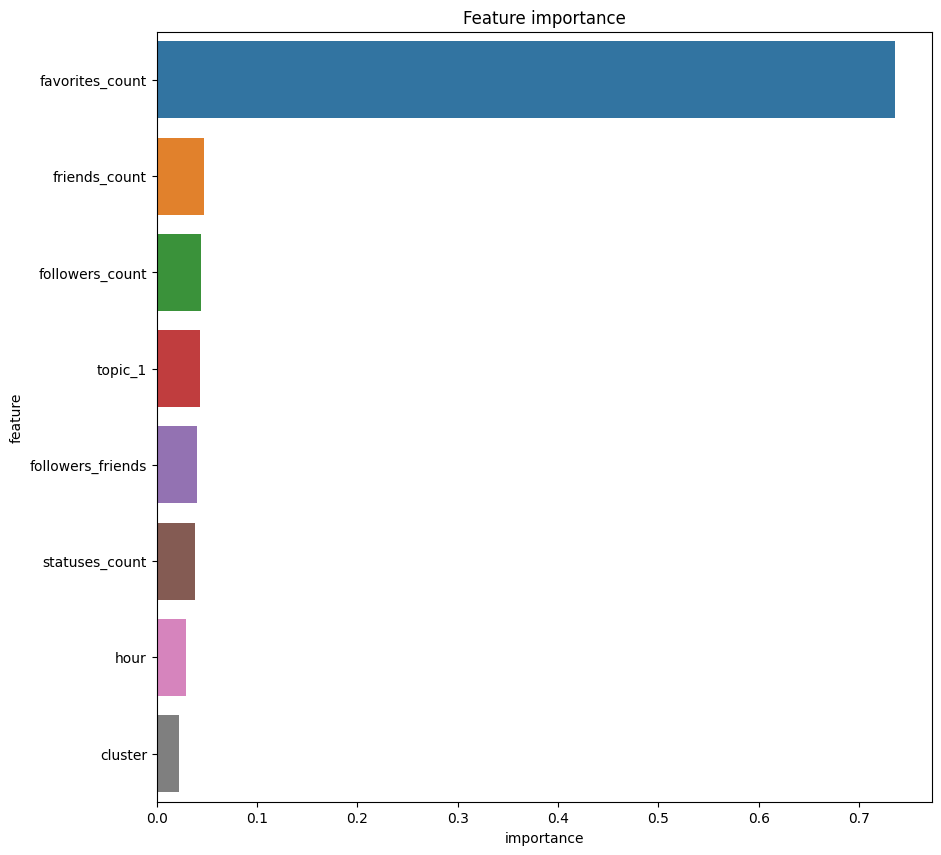

<AxesSubplot: >

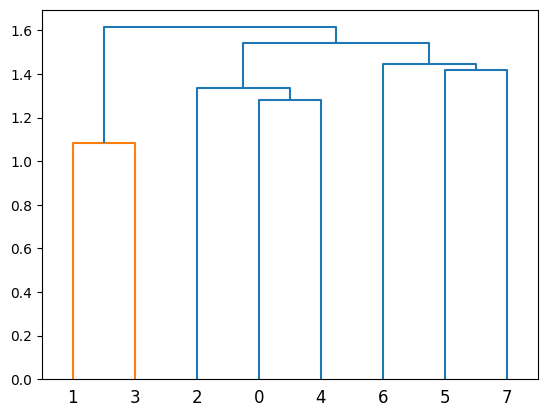

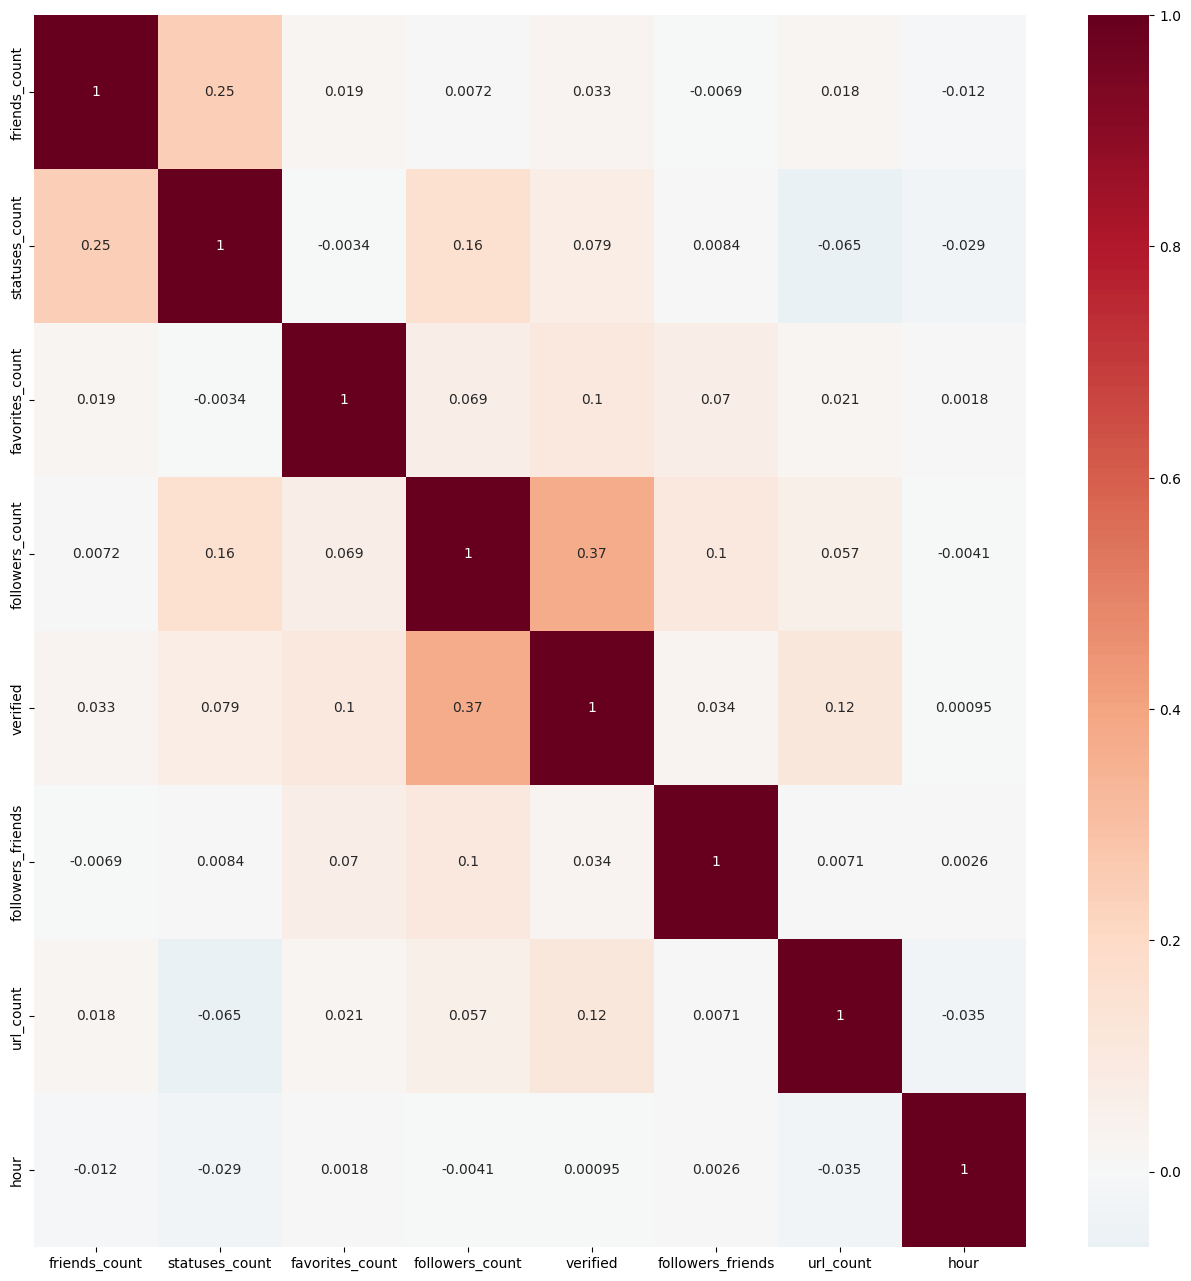

In [17]:
import seaborn as sbn
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
feature_importance = pd.DataFrame({'feature': new_X_train.drop(
    remove, axis=1).columns, 'importance': model.feature_importances_})
plt.figure(figsize=(10, 10))
sns.barplot(data=feature_importance.sort_values(
    by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature importance')
plt.show()


# plot correlation of features

order = np.array(hierarchy.dendrogram(
    hierarchy.ward(new_X_train.drop(remove, axis=1).corr()), no_plot=False)['ivl'], dtype="int")

rearranged_cov = new_X_train.drop(
    ['TweetID'], axis=1).corr().iloc[order, order]

plt.figure(figsize=(16, 16))

sbn.heatmap(rearranged_cov, annot=True, cmap="RdBu_r", center=0)

In [18]:
feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
2,favorites_count,0.735569
1,friends_count,0.047219
0,followers_count,0.044215
6,topic_1,0.043150
4,followers_friends,0.040135
3,statuses_count,0.038584
5,hour,0.029046
7,cluster,0.022083


In [19]:
# plot model mae with number of top features
# TO DO
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest

In [ ]:
# plot model mae with number of top features

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#from sklearn.neural_network import MLPRegressor
#from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
#from sklearn.ensemble import ExtraTreesRegressor

# The model
#model = automl.model.estimator

# Get Accuracy

acc = []
new_X_train2 = new_X_train.drop(remove, axis=1)
new_X_test2 = new_X_test.drop(remove, axis=1)

for i in range(1, len(col) - len(remove)):
    # apply SelectKBest class to extract top i best features
    k_best_fit = SelectKBest(score_func=f_regression, k=i).fit(new_X_train2, y_train)
    # transform both train and test
    X_train_new = k_best_fit.transform(new_X_train2)
    X_test_new = k_best_fit.transform(new_X_test2)
    # fit the model and predict
    model.fit(X_train_new, y_train)
    y_pred = model.predict(X_test_new)
    y_pred = [round(value) if value >= 0 else 0 for value in y_pred]
    acc.append(mean_absolute_error(y_test, y_pred))

# Plot
plt.figure(figsize=(16, 6))
plt.plot(range(1, len(col) - len(remove)), acc, c='b')
plt.title("MAE depending on number of top features")
plt.xlabel("Number of top features")
plt.ylabel("MAE")
plt.show()

# Get best features
k_best_fit = SelectKBest(score_func=f_regression, k=np.argmin(np.array(acc))).fit(new_X_train2, y_train)
n_best = 1 + np.argmin(np.array(acc))
best_features_names = [x for _, x in sorted(zip(k_best_fit.scores_, k_best_fit.feature_names_in_), reverse=True)][:n_best]
print(best_features_names)

In [ ]:
# Only the plot
plt.figure(figsize=(16, 6))
plt.plot(range(1, len(col) - len(remove)), acc, c='b')
plt.title("MAE depending on number of top features")
plt.xlabel("Number of top features")
plt.ylabel("MAE")
plt.show()

In [ ]:
# Only the best features names
k_best_fit = SelectKBest(score_func=f_regression, k=np.argmin(np.array(acc))).fit(new_X_train2, y_train)
n_best = 1 + np.argmin(np.array(acc))
best_features_names = [x for _, x in sorted(zip(k_best_fit.scores_, k_best_fit.feature_names_in_), reverse=True)][:n_best]
print(best_features_names)

### Models to consider

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, new_X_train.drop(remove, axis=1), y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)